<h1 style="text-align:center;color:#06344ef6;font-size:50px;font-family:Bell MT ;border:solid"> Initiation au machine learning : Projet final 2023 - 2024 </h1>

<div style="display:flex;text-align:justify">
    
<ul style="text-align:justify;font-family:bodoni MT;font-size:25px;list-style-type:circle; width:60%"> 
<span style="font-weight:bold">Réalisé par: </span> 
    <ul style="text-align:justify;font-family:times;font-size:18px;list-style-type:circle"> 
        <li>Fallou BADJI</li>   
        <li> Pathé DIAGNE</li>                                      
        <li>Diakhou NDAO</li>
        <li>Marie Agathe SECK</li>
    </ul>
    <span style="font-style:italic;color:#06344ef6;font-size:14px">Eléves Ingénieurs statisticiens économistes</span>
</ul>
 
<ul style="text-align:justify;font-family:bodoni MT;font-size:23px;list-style-type:none;width:39%"> 
 <li style="font-weight:bold">Sous la supervision de:</li> 
<li>Mme Mously DIAW</li>                                     
  <span style="font-style:italic;color:#06344ef6;font-size:15px"> Machine Learning Engineer - Formatrice IA </span>
</ul>
    
</div>

<h1 style="text-align:center;color:#06344ef6;font-size:30px;font-family:bodoni MT"> Objectif : Prédiction de la consommation d'énergie des batiments non destinés à l'habitation de la ville de Seattle</h1>

Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, nous nous intéressons de près à la consommation totale d’énergie des bâtiments non destinés à l’habitation de la ville de Seattle.
    Nos prédictions se baseront sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..).

**<h1 style="color:#06344ef6;text-align:center;font-size:35px;font-family:Bodoni MT"> MODELISATION </h1>**


## importation des modules

In [144]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import scipy as sp
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_error,
                             max_error,
                             mean_absolute_percentage_error
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
from plotly.subplots import make_subplots
import plotly.graph_objects as go

set_config(display="diagram", print_changed_only=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Supprimer les avertissements 
import warnings
warnings.filterwarnings("ignore")

## Fonction pour evaluer les performances des modèles

In [145]:
def get_all_performances(value_train: tuple,
                         values_test: tuple,
                         metrics: list,
                        ) -> pd.DataFrame:
    """ Get all performance metrics listed in `metrics`
    
    Args:
        value_train (tuple): (y_train, y_train_pred)
        values_test (tuple): (y_test, y_test_pred)
        metrics (list): list of metrics to compute
    
    
    Returns:
        pd.DataFrame: column names are: ["metric", "train", "test"]
        
    """
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

In [146]:
METRICS = [r2_score,
           mean_squared_error,
           max_error,
          ]

## importation des données apurées

In [147]:
# repertoire courant
%pwd

'C:\\Users\\LENOVO\\projet_ML\\notebooks'

In [148]:
# Importation 
data = pd.read_csv('../data/building-energy-apure.csv') 

In [149]:
data.describe()

,OSEBuildingID,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,UseTypeNumber,Age_building,proplargestUseGFA
count,1542.000000,1542.000000,1542.000000,1542.000000,1.542000e+03,1542.000000,1.542000e+03,1.542000e+03,1542.000000,1542.000000,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1542.000000,1542.000000,1542.000000,1542.000000
mean,16595.957847,1961.282750,1.070039,4.272374,1.116054e+05,13703.575875,9.761001e+04,8.980596e+04,64.147601,74.187743,7.587435e+06,2.959540e+05,5.127372e+06,1.528227e+06,144.886835,1.938392,54.717250,85.777916
std,13859.126565,32.891191,0.535826,6.605977,1.886955e+05,42471.306372,1.639475e+05,1.510265e+05,25.042557,74.817541,1.774943e+07,1.721714e+06,9.604610e+06,3.431402e+06,301.563534,1.204886,32.891191,29.879999
min,1.000000,1900.000000,1.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,18.646908
25%,609.250000,1929.000000,1.000000,1.000000,2.877000e+04,0.000000,2.770000e+04,2.476625e+04,49.650000,34.325000,1.206500e+06,0.000000e+00,7.100620e+05,0.000000e+00,19.450000,1.000000,28.000000,66.865572
50%,21212.500000,1965.000000,1.000000,2.000000,4.730250e+04,0.000000,4.511350e+04,4.126550e+04,68.200000,53.200001,2.615611e+06,0.000000e+00,1.633988e+06,4.348840e+05,48.425000,2.000000,51.000000,93.353417
75%,24629.750000,1988.000000,1.000000,4.000000,1.029825e+05,0.000000,9.296300e+04,8.847600e+04,83.950000,83.775002,6.978706e+06,0.000000e+00,5.018711e+06,1.413123e+06,137.197500,2.000000,87.000000,100.000000
max,50226.000000,2015.000000,9.000000,76.000000,1.592914e+06,368980.000000,1.400000e+06,1.350182e+06,100.000000,707.299988,2.538325e+08,1.754842e+07,6.863682e+07,3.006132e+07,2573.750000,13.000000,116.000000,642.684902


In [150]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542 entries, 0 to 1541
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              1542 non-null   int64  
 1   BuildingType               1542 non-null   object 
 2   PrimaryPropertyType        1542 non-null   object 
 3   Neighborhood               1542 non-null   object 
 4   YearBuilt                  1542 non-null   int64  
 5   NumberofBuildings          1542 non-null   float64
 6   NumberofFloors             1542 non-null   int64  
 7   PropertyGFATotal           1542 non-null   int64  
 8   PropertyGFAParking         1542 non-null   int64  
 9   PropertyGFABuilding(s)     1542 non-null   int64  
 10  LargestPropertyUseType     1542 non-null   object 
 11  LargestPropertyUseTypeGFA  1542 non-null   float64
 12  ENERGYSTARScore            1542 non-null   float64
 13  SiteEUI(kBtu/sf)           1542 non-null   float

## Sélection des variables explicatives

In [151]:
X = data[['PrimaryPropertyType', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors',  'PropertyGFATotal', 
                'SteamUse(kBtu)', 'Electricity(kBtu)','NaturalGas(kBtu)', 'TotalGHGEmissions',
                'UseTypeNumber', 'Age_building', 'proplargestUseGFA', 'ENERGYSTARScore']]
X.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,UseTypeNumber,Age_building,proplargestUseGFA,ENERGYSTARScore
0,Hotel,DOWNTOWN,1.0,12,88434,2003882.00,3946027.0,1276453.0,249.98,1,89,100.000000,60.0
1,Hotel,DOWNTOWN,1.0,11,103566,0.00,3242851.0,5145082.0,295.86,3,20,80.991831,61.0
2,Hotel,DOWNTOWN,1.0,41,956110,17548416.00,49526664.0,1493800.0,2089.28,1,47,79.121963,43.0
3,Hotel,DOWNTOWN,1.0,10,61320,2214446.25,2768924.0,1811213.0,286.43,1,90,100.000000,56.0
4,Hotel,DOWNTOWN,1.0,18,175580,0.00,5368607.0,8803998.0,505.01,3,36,70.306983,75.0


Création des variables Dummy pour les index des feature importances

__Séparer les variables quantitatives des qualitatives__

In [152]:
categorical_features = X.select_dtypes(include="object").columns
print(f"Categorical features:\n {categorical_features}\n")

numerical_features = X.select_dtypes(include=['int64','float64']).columns
print(f"Numerical features:\n {numerical_features}")

Categorical features:
 Index(['PrimaryPropertyType', 'Neighborhood'], dtype='object')

Numerical features:
 Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'UseTypeNumber', 'Age_building',
       'proplargestUseGFA', 'ENERGYSTARScore'],
      dtype='object')


In [153]:
X_encode = pd.get_dummies(data=X,
                          columns=categorical_features,
                          drop_first=True,
                         )
X_encode.shape

(1542, 43)

__Définition de la variable cible__

In [154]:
Y = data['SiteEnergyUse(kBtu)']

## Séparation en train et test (80-20)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=12)
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1233 lignes,
Test: 309 lignes.



## Pipeline pour les modèles

Dans le pipeline, nous allons normaliser les variables quantitatives pour se ramener à la même échelle (centrer et reduire) et transformer les variables catégorielles en dummy variables.

In [156]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', drop='first')
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_transform", numeric_transformer, numerical_features),
        ("cat_transform", categorical_transformer, categorical_features)
    ]
)
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num_transform',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu...
                                 Pipeline(memory=None,
                                          steps=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                feature_name_combiner='concat',
                                                                handle_unknown='ignore',
                                                                max_categories=None,
                                                                min_frequency=None,
                                                                sparse_output=True))],
                                          verbose=False),
                                 Index(['PrimaryPropertyType', 'Neighborhood'], dtype='object'))],
                  verbose=False, verbose_feature_names_out=True)

## REGRESSION LINEAIRE

In [157]:
lr_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
lr_pipe

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 feature_name_combiner='concat',
                                                                                 handle_unknown='ignore',
                                                                                 max_categories=None,
                                                                                 min_frequency=None,
                                                                                 sparse_output=True))],
                                                           verbose=False),
                                                  Index(['PrimaryPropertyType', 'Neighborhood'], dtype='object'))],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  positive=False))],
         verbose=False)

### Optimisation des hyperparamètres

In [158]:
# definir les hyperparametres
param_grid_lr = {
    "regressor__fit_intercept": [True, False],
}

GS_lr = GridSearchCV(lr_pipe, param_grid_lr, cv=10, scoring="r2", return_train_score=True)
GS_lr

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_transform',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                                                                                         with_std=True))],
                                                                                  verbose=False),
                                                                         Index(['NumberofBuildings',...
                                                                         Index(['PrimaryPropertyType', 'Neighborhood'], dtype='object'))],
                                                          verbose=False,
                                                          verbose_feature_names_out=True)),
                                       ('regressor',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         positive=False))],
                                verbose=False),
             n_jobs=None,
             param_grid={'regressor__fit_intercept': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [159]:
# Exécuter la recherche sur la grille
GS_lr.fit(X_train, y_train)
# meilleur combinaison
best_params = GS_lr.best_params_
print(f"Best params: {best_params}")


Best params: {'regressor__fit_intercept': True}


In [160]:
grid_cv_results = GS_lr.cv_results_
pd.DataFrame(grid_cv_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.141669,0.367541,0.014591,0.010794,True,{'regressor__fit_intercept': True},0.880878,0.554338,0.939320,0.854388,0.969225,0.953112,0.923187,0.754008,0.936408,0.663912,0.842878,0.133181,1,0.908787,0.956991,0.907107,0.909736,0.900909,0.901620,0.900461,0.916639,0.906865,0.926280,0.913540,0.016296
1,0.017291,0.003436,0.007496,0.001499,False,{'regressor__fit_intercept': False},0.871994,0.553875,0.933642,0.861262,0.966347,0.947765,0.922553,0.746712,0.927784,0.659525,0.839146,0.132468,2,0.905971,0.953955,0.904428,0.906755,0.898310,0.899213,0.897085,0.914189,0.904454,0.923783,0.910814,0.016252


### Evaluer les performances

In [161]:
# predictions
y_test_pred_lr = GS_lr.predict(X_test)
y_train_pred_lr = GS_lr.predict(X_train)

In [162]:
# get performances in train & test
get_all_performances(value_train=(y_train, y_train_pred_lr),
                     values_test=(y_test, y_test_pred_lr),
                     metrics=METRICS)

,metric,train,test
0,r2_score,9.086625e-01,8.487660e-01
1,mean_squared_error,2.903719e+13,4.571123e+13
2,max_error,1.080399e+08,8.597776e+07


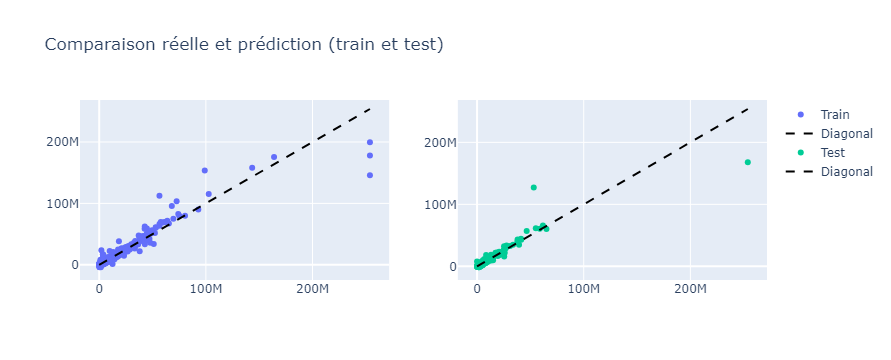

In [163]:
## Comparaison réelle et prédiction (train et test)
fig = make_subplots(rows=1, cols=2, shared_yaxes=False)

datasets = [("Train", y_train, y_train_pred_lr), ("Test", y_test, y_test_pred_lr)]

for idx, (name, y_true, y_pred) in enumerate(datasets):
    col = idx + 1
    fig.add_trace(go.Scatter(x=y_true, y=y_pred, mode="markers", name=name), row=1, col=col)

    fig.add_trace(go.Scatter(x=[y_true.min(), y_true.max()],
                             y=[y_true.min(), y_true.max()],
                             mode="lines", name="Diagonal", line=dict(color="black", dash="dash")),
                  row=1, col=col)

fig.update_layout(title_text="Comparaison réelle et prédiction (train et test)", showlegend=True)
fig.show()


### Analyse des résidus

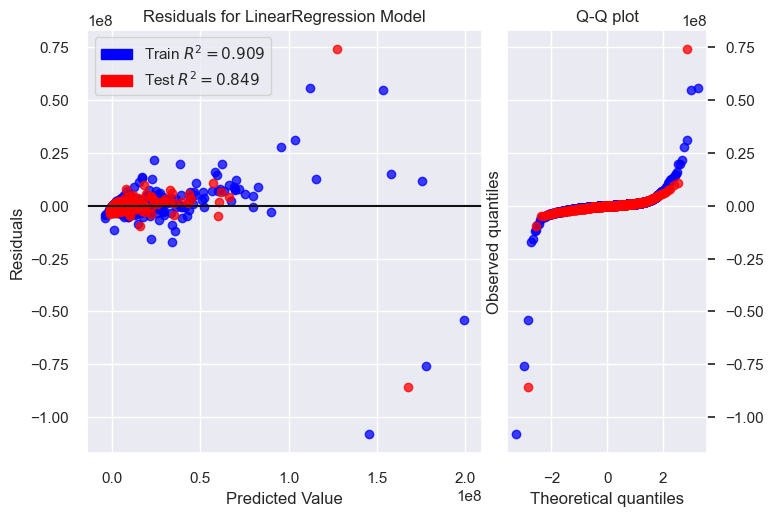

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

<Figure size 800x550 with 0 Axes>

In [164]:
# Visualisation des résidus
from yellowbrick.regressor import ResidualsPlot

res_viz = ResidualsPlot(lr_pipe,
                        is_fitted="auto",
                        qqplot=True,
                        hist=False,
                        train_color="blue",
                        test_color="red"
                       )
res_viz.fit(X_train, y_train)
res_viz.score(X_test, y_test)
res_viz.show(clear_figure=True)


## ElacticNet 

### Définir le modèle

In [165]:
EN_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", ElasticNet())]
)
EN_pipe

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                                                                                 sparse_output=True))],
                                                           verbose=False),
                                                  Index(['PrimaryPropertyType', 'Neighborhood'], dtype='object'))],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                            l1_ratio=0.5, max_iter=1000, positive=False,
                            precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [166]:
EN_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                                                                                 sparse_output=True))],
                                                           verbose=False),
                                                  Index(['PrimaryPropertyType', 'Neighborhood'], dtype='object'))],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                            l1_ratio=0.5, max_iter=1000, positive=False,
                            precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [167]:
# predictions
y_test_pred_EN = EN_pipe.predict(X_test)
y_train_pred_EN = EN_pipe.predict(X_train)

In [168]:
# get performances in train & test
get_all_performances(value_train=(y_train, y_train_pred_EN),
                     values_test=(y_test, y_test_pred_EN),
                     metrics=METRICS)

,metric,train,test
0,r2_score,8.149415e-01,7.843420e-01
1,mean_squared_error,5.883215e+13,6.518371e+13
2,max_error,1.770125e+08,1.345517e+08


### Optimisation des hyperparamètres

In [169]:
# optimisation des hyperparamètres
param_grid_EN = {
    "regressor__alpha": [0.005, 0.01, 0.2, 0.3, 0.5, 0.7],
    "regressor__l1_ratio" : [0.001, 0.01, 0.5, 0.3, 0.7, 0.8],
    "regressor__fit_intercept" : [True, False]
}

GS_EN = GridSearchCV(EN_pipe, param_grid_EN, cv=5, scoring="r2", return_train_score=True)

In [170]:
# les meilleurs paramètres
GS_EN.fit(X_train, y_train)

best_params = GS_EN.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__alpha': 0.3, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.8}


In [171]:
# entrainement du meilleur modele
best_elasticnet_model = GS_EN.best_estimator_
best_elasticnet_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                                                                                 sparse_output=True))],
                                                           verbose=False),
                                                  Index(['PrimaryPropertyType', 'Neighborhood'], dtype='object'))],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 ElasticNet(alpha=0.3, copy_X=True, fit_intercept=True,
                            l1_ratio=0.8, max_iter=1000, positive=False,
                            precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

### Evaluation des performances

In [172]:
# get performances in train & test
get_all_performances(value_train=(y_train, best_elasticnet_model.predict(X_train)),
                     values_test=(y_test, best_elasticnet_model.predict(X_test)),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,8.798284e-01,8.433531e-01
1,mean_squared_error,3.820389e+13,4.734731e+13
2,max_error,1.343753e+08,1.082305e+08


### Feature importance

In [173]:
# future importance
df_feature_importance = pd.DataFrame(best_elasticnet_model['regressor'].coef_, columns=["coef"], index=X_encode.columns)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (43, 1)


,coef
NumberofBuildings,2.478955e+06
NumberofFloors,-3.842343e+05
PropertyGFATotal,6.708349e+05
SteamUse(kBtu),-5.493758e+05
Electricity(kBtu),9.203627e+06


<BarContainer object of 43 artists>

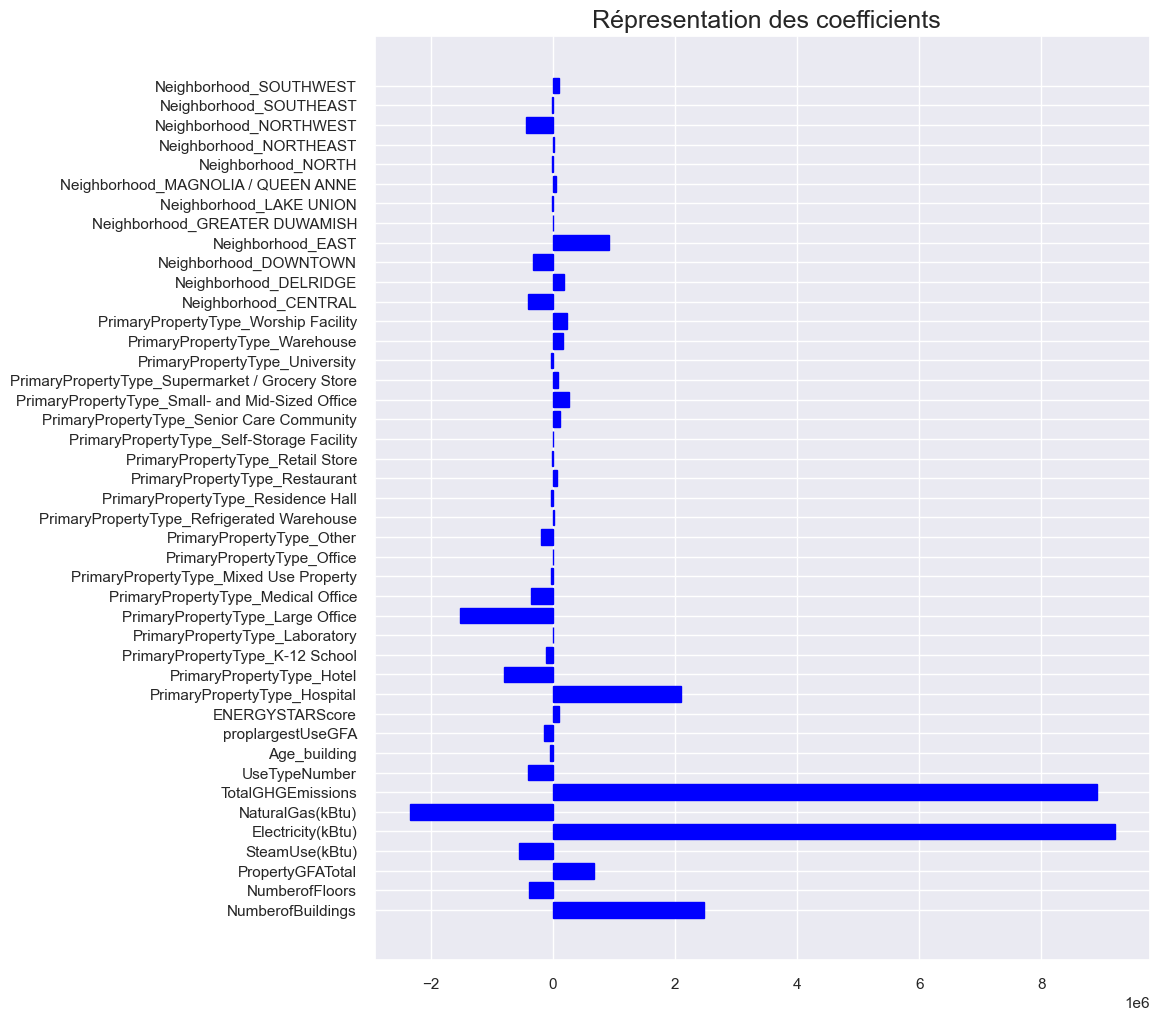

In [174]:
fig=plt.figure(figsize=[10,12])
fig.patch.set_alpha(0.7)
plt.title(" Répresentation des coefficients",size=18)
plt.barh(X_encode.columns, best_elasticnet_model['regressor'].coef_,color="#0000FF",edgecolor='blue')


## Random Forest 

### Définir le modèle

In [175]:
randf_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor())]
)
randf_pipe

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='squared_error',
                                       max_depth=None, max_features=1.0,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       monotonic_cst=None, n_estimators=100,
                                       n_jobs=None, oob_score=False,
                                       random_state=None, verbose=0,
                                       warm_start=False))],
         verbose=False)

In [176]:
# Premier entrainement
randf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='squared_error',
                                       max_depth=None, max_features=1.0,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       monotonic_cst=None, n_estimators=100,
                                       n_jobs=None, oob_score=False,
                                       random_state=None, verbose=0,
                                       warm_start=False))],
         verbose=False)

In [177]:
# get performances in train & test
get_all_performances(value_train=(y_train, randf_pipe.predict(X_train)),
                     values_test=(y_test, randf_pipe.predict(X_test)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,9.830239e-01,9.629631e-01
1,mean_squared_error,5.396903e+12,1.119458e+13
2,max_error,6.568448e+07,5.393810e+07


### Optimisation des hyperparamètres

In [178]:
# optimisation des hyperparamètres
param_grid_rf = {
    'regressor__n_estimators': [700, 600],
     'regressor__min_samples_split': [5],
    'regressor__max_depth': [None],
    'regressor__min_samples_leaf': [2],
    #'regressor__max_features': ['auto'],#'sqrt'
    'regressor__bootstrap': [True], # False
}
                                
GS_rf = GridSearchCV(randf_pipe, param_grid_rf, cv=5, scoring="r2", return_train_score=True)
GS_rf

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_transform',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                                                                                         with_std=True))],
                                                                                  verbose=False),
                                                                         Index(['NumberofBuildings', '...
                                                              oob_score=False,
                                                              random_state=None,
                                                              verbose=0,
                                                              warm_start=False))],
                                verbose=False),
             n_jobs=None,
             param_grid={'regressor__bootstrap': [True],
                         'regressor__max_depth': [None],
                         'regressor__min_samples_leaf': [2],
                         'regressor__min_samples_split': [5],
                         'regressor__n_estimators': [700, 600]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [179]:
# les meilleurs paramètres
GS_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_transform',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                                                                                         with_std=True))],
                                                                                  verbose=False),
                                                                         Index(['NumberofBuildings', '...
                                                              oob_score=False,
                                                              random_state=None,
                                                              verbose=0,
                                                              warm_start=False))],
                                verbose=False),
             n_jobs=None,
             param_grid={'regressor__bootstrap': [True],
                         'regressor__max_depth': [None],
                         'regressor__min_samples_leaf': [2],
                         'regressor__min_samples_split': [5],
                         'regressor__n_estimators': [700, 600]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [180]:
# les meilleurs paramètres
best_params = GS_rf.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__bootstrap': True, 'regressor__max_depth': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 600}


In [181]:
# entrainement du meilleur modele
best_randf_model = GS_rf.best_estimator_
best_randf_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='squared_error',
                                       max_depth=None, max_features=1.0,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_samples_leaf=2, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0,
                                       monotonic_cst=None, n_estimators=600,
                                       n_jobs=None, oob_score=False,
                                       random_state=None, verbose=0,
                                       warm_start=False))],
         verbose=False)

### Evaluation des performances

In [182]:
# get performances in train & test
get_all_performances(value_train=(y_train, best_randf_model.predict(X_train)),
                     values_test=(y_test, best_randf_model.predict(X_test)),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,9.602116e-01,9.441342e-01
1,mean_squared_error,1.264917e+13,1.688571e+13
2,max_error,8.409765e+07,6.532049e+07


### Feature importance

In [183]:
# future importance
df_feature_importance = pd.DataFrame(best_randf_model['regressor'].feature_importances_, columns=["coef"], index=X_encode.columns)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (43, 1)


,coef
NumberofBuildings,0.019653
NumberofFloors,0.002093
PropertyGFATotal,0.003507
SteamUse(kBtu),0.001483
Electricity(kBtu),0.694774


<BarContainer object of 43 artists>

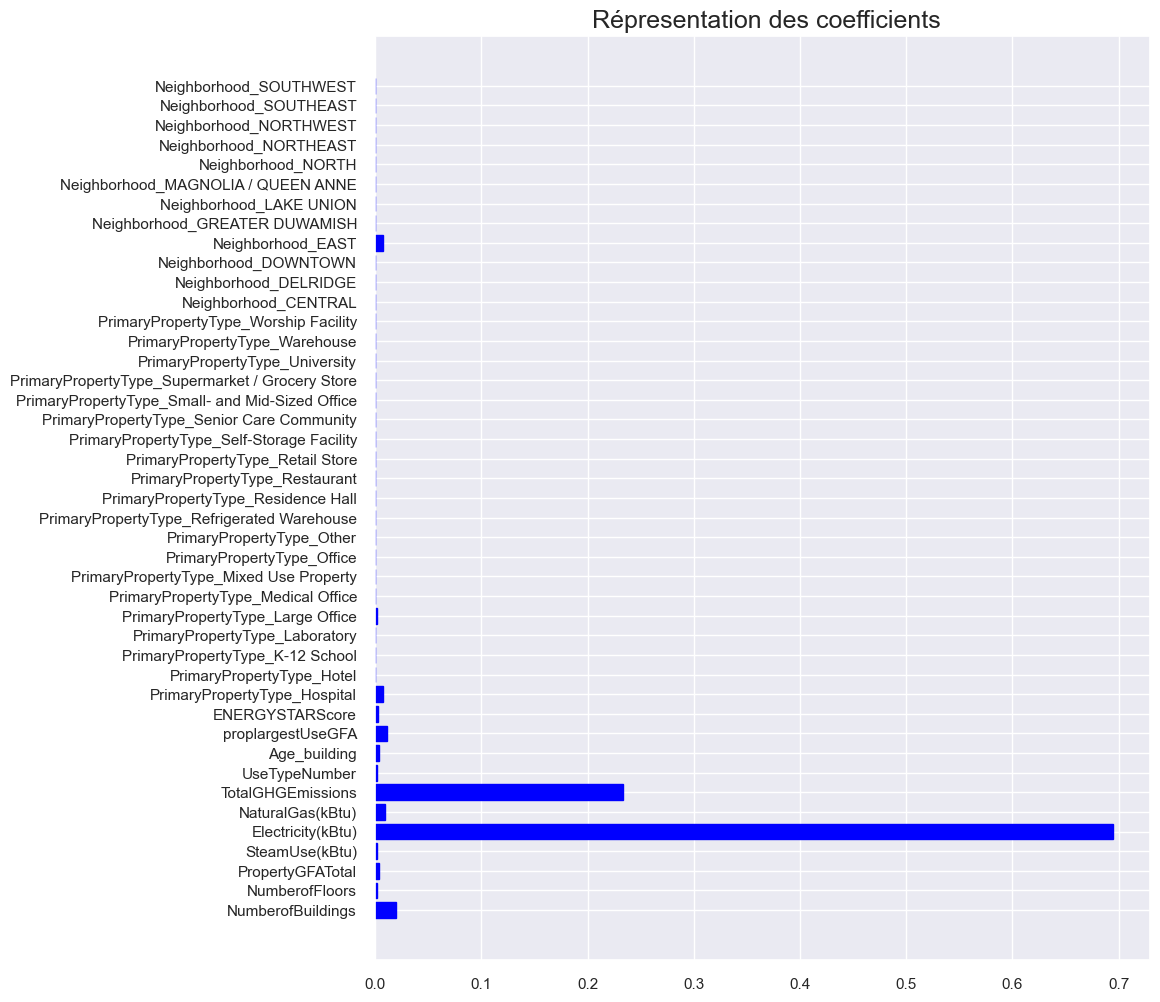

In [184]:
fig=plt.figure(figsize=[10,12])
fig.patch.set_alpha(0.7)
plt.title(" Répresentation des coefficients",size=18)
plt.barh(X_encode.columns, best_randf_model['regressor'].feature_importances_,color="#0000FF",edgecolor='blue')


## XGBoost 

### Définir le modèle

In [185]:
xgb_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor())]
)
xgb_pipe

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              objective='reg:squarederror', predictor=None, ...))],
         verbose=False)

In [186]:
# Premier entrainement
xgb_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              objective='reg:squarederror', predictor=None, ...))],
         verbose=False)

In [187]:
# get performances in train & test
get_all_performances(value_train=(y_train, xgb_pipe.predict(X_train)),
                     values_test=(y_test, xgb_pipe.predict(X_test)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,9.999967e-01,9.924381e-01
1,mean_squared_error,1.039781e+09,2.285607e+12
2,max_error,2.566768e+05,1.389186e+07


### Optimisation des hyperparamètres

In [188]:
# optimisation des hyperparamètres
param_grid_xgb = {
     "regressor__n_estimators" : [100, 200, 300],
    "regressor__max_depth" : [3, 6, 9],
    "regressor__gamma" : [0.01, 0.1],
    "regressor__learning_rate" : [0.001, 0.01, 0.1, 1]
}
GS_xgb = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5, scoring="r2", return_train_score=True)
GS_xgb

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_transform',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                                                                                         with_std=True))],
                                                                                  verbose=False),
                                                                         Index(['NumberofBuildings', '...
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     objective='reg:squarederror',
                                                     predictor=None, ...))],
                                verbose=False),
             n_jobs=None,
             param_grid={'regressor__gamma': [0.01, 0.1],
                         'regressor__learning_rate': [0.001, 0.01, 0.1, 1],
                         'regressor__max_depth': [3, 6, 9],
                         'regressor__n_estimators': [100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [189]:
# les meilleurs paramètres
GS_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_transform',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                                                                                         with_std=True))],
                                                                                  verbose=False),
                                                                         Index(['NumberofBuildings', '...
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     objective='reg:squarederror',
                                                     predictor=None, ...))],
                                verbose=False),
             n_jobs=None,
             param_grid={'regressor__gamma': [0.01, 0.1],
                         'regressor__learning_rate': [0.001, 0.01, 0.1, 1],
                         'regressor__max_depth': [3, 6, 9],
                         'regressor__n_estimators': [100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [190]:
# les meilleurs paramètres
best_params = GS_xgb.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__gamma': 0.01, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300}


In [191]:
# entrainement du meilleur modele
best_xgb_model = GS_xgb.best_estimator_
best_xgb_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None,
                              objective='reg:squarederror', predictor=None, ...))],
         verbose=False)

### Evaluation des performances

In [192]:
# predictions
y_train_predXGB = best_xgb_model.predict(X_train)
y_test_predXGB = best_xgb_model.predict(X_test)

# get performances in train & test
get_all_performances(value_train=(y_train, y_train_predXGB),
                     values_test=(y_test, y_test_predXGB),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,9.998859e-01,9.960132e-01
1,mean_squared_error,3.627649e+10,1.205030e+12
2,max_error,2.737104e+06,8.491228e+06


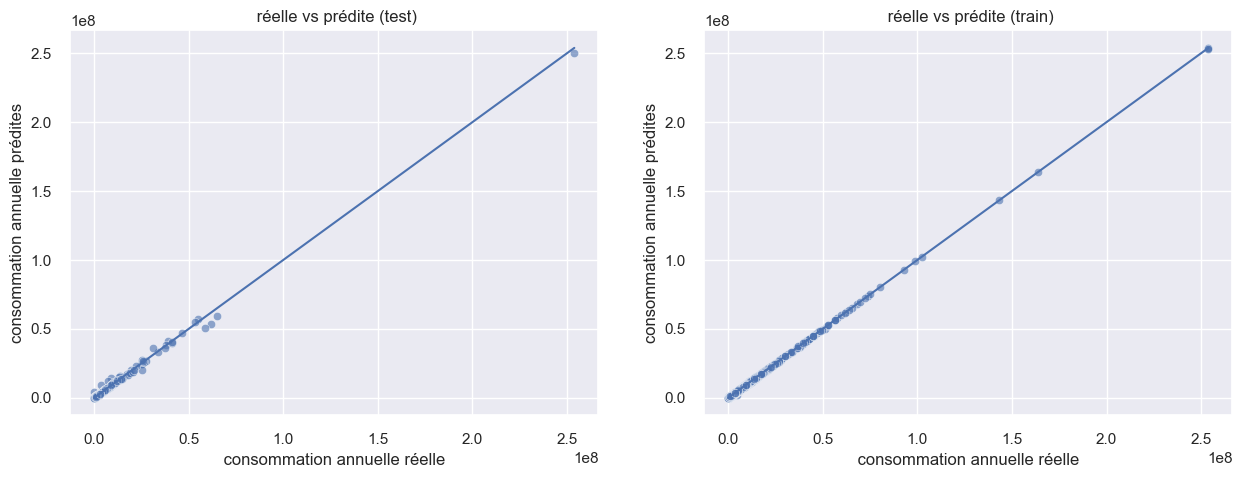

In [193]:
# graphique
sns.set()
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x = y_test, y = y_test_predXGB, alpha = 0.6, ax = axs[0])
sns.lineplot(y_test, y_test, ax = axs[0])
axs[0].set_xlabel(" consommation annuelle réelle ")
axs[0].set_ylabel("consommation annuelle prédites")
axs[0].set_title(" réelle vs prédite (test)")
sns.scatterplot(x = y_train, y = y_train_predXGB, alpha = 0.6, ax = axs[1])
sns.lineplot(y_train, y_train, ax = axs[1])
axs[1].set_xlabel(" consommation annuelle réelle ")
axs[1].set_ylabel("consommation annuelle prédites")
axs[1].set_title(" réelle vs prédite (train)")
plt.show()

__Modèle très performant__

### Feature importance

In [194]:
# future importance
df_feature_importance = pd.DataFrame(best_xgb_model['regressor'].feature_importances_, columns=["coef"], index=X_encode.columns)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (43, 1)


,coef
NumberofBuildings,0.000916
NumberofFloors,0.005589
PropertyGFATotal,0.005389
SteamUse(kBtu),0.000887
Electricity(kBtu),0.604749


<BarContainer object of 43 artists>

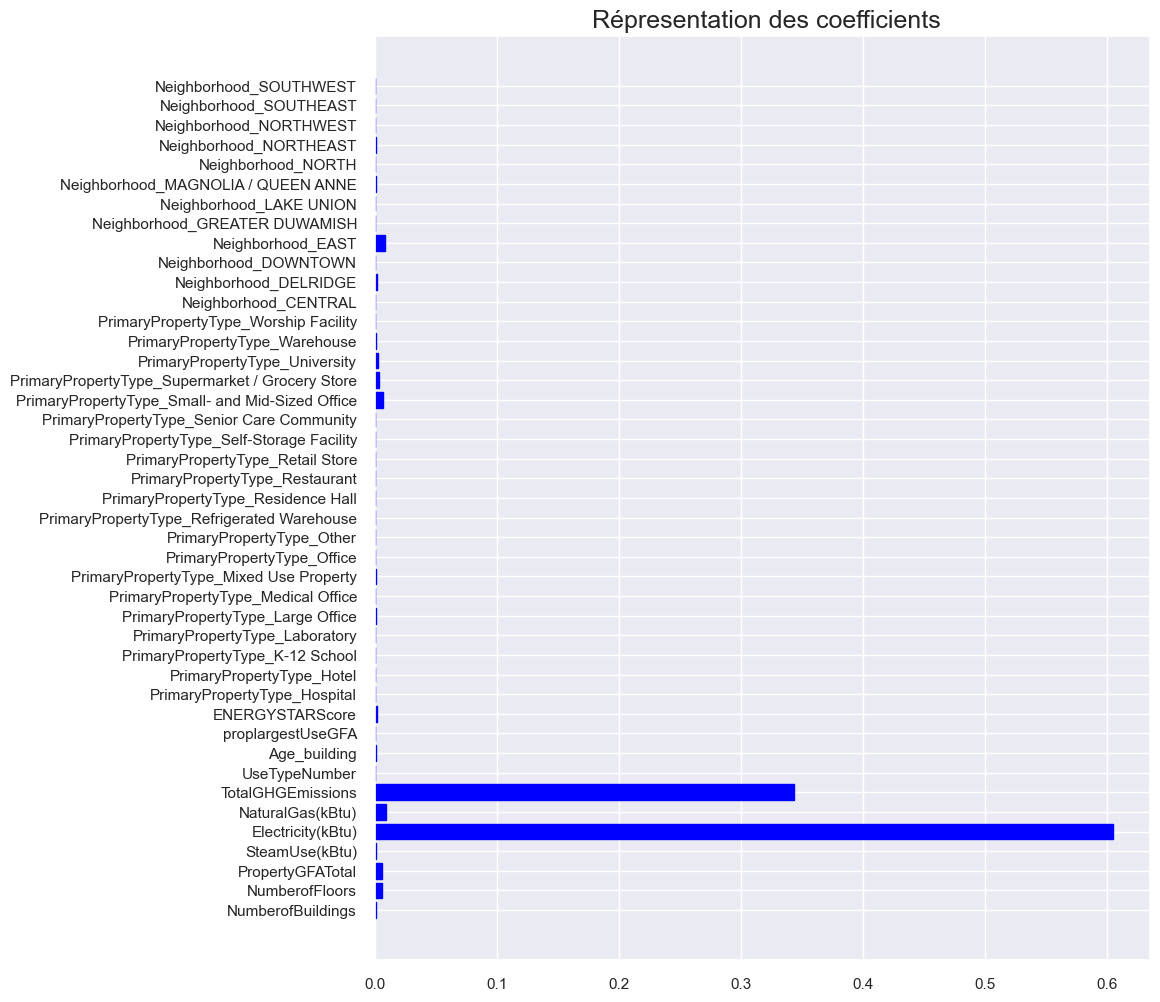

In [195]:
fig=plt.figure(figsize=[10,12])
fig.patch.set_alpha(0.7)
plt.title(" Répresentation des coefficients",size=18)
plt.barh(X_encode.columns, best_xgb_model['regressor'].feature_importances_,color="#0000FF",edgecolor='blue')


## Light GBM

### Définir le modèle

In [196]:
lgbm_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LGBMRegressor())]
)
lgbm_pipe

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
                               learning_rate=0.1, max_depth=-1,
                               min_child_samples=20, min_child_weight=0.001,
                               min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                               subsample=1.0, subsample_for_bin=200000,
                               subsample_freq=0))],
         verbose=False)

In [197]:
# premier entrainement
lgbm_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
                               learning_rate=0.1, max_depth=-1,
                               min_child_samples=20, min_child_weight=0.001,
                               min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                               subsample=1.0, subsample_for_bin=200000,
                               subsample_freq=0))],
         verbose=False)

In [198]:
# get performances in train & test
get_all_performances(value_train=(y_train, lgbm_pipe.predict(X_train)),
                     values_test=(y_test, lgbm_pipe.predict(X_test)),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,8.848330e-01,7.895806e-01
1,mean_squared_error,3.661286e+13,6.360032e+13
2,max_error,1.066878e+08,1.039132e+08


Overfitting

### Optimisation des hyperparamètres

In [199]:
# optimisation des hyperparamètres
param_grid_lgb = {
    'regressor__num_leaves': [131, 255],
    'regressor__max_depth': [-1, 30],
    'regressor__learning_rate': [0.001, 0.2],
    'regressor__n_estimators': [10, 50],
   # 'regressor__min_split_gain': [0.0, 0.2],
    #'regressor__min_child_samples': [10, 30],
    #'regressor__subsample': [0.8, 0.9, 1.0],
    #'regressor__reg_alpha': [0.0, 0.1, 0.5],
    #'regressor__reg_lambda': [0.001, 0.1],
    #'regressor__objective': ['mse'],
    #'regressor__feature_fraction': 0.75,
    #'regressor__bagging_fraction': 0.75,
    #'regressor__bagging_freq': 5,
}

GS_lgb = GridSearchCV(xgb_pipe, param_grid_lgb, cv=5, scoring="r2", return_train_score=True)
GS_lgb

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_transform',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                                                                                         with_std=True))],
                                                                                  verbose=False),
                                                                         Index(['NumberofBuildings', '...
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     objective='reg:squarederror',
                                                     predictor=None, ...))],
                                verbose=False),
             n_jobs=None,
             param_grid={'regressor__learning_rate': [0.001, 0.2],
                         'regressor__max_depth': [-1, 30],
                         'regressor__n_estimators': [10, 50],
                         'regressor__num_leaves': [131, 255]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [200]:
# les meilleurs paramètres
GS_lgb.fit(X_train, y_train)

[01:02:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[01:02:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[01:02:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[01:02:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[01:02:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_leaves" } are not used.



GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_transform',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                                                                                         with_std=True))],
                                                                                  verbose=False),
                                                                         Index(['NumberofBuildings', '...
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     objective='reg:squarederror',
                                                     predictor=None, ...))],
                                verbose=False),
             n_jobs=None,
             param_grid={'regressor__learning_rate': [0.001, 0.2],
                         'regressor__max_depth': [-1, 30],
                         'regressor__n_estimators': [10, 50],
                         'regressor__num_leaves': [131, 255]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [201]:
# les meilleurs paramètres
best_params = GS_lgb.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 30, 'regressor__n_estimators': 10, 'regressor__num_leaves': 131}


In [202]:
# entrainement du meilleur modele
best_lgb_model = GS_lgb.best_estimator_
best_lgb_model.fit(X_train,y_train)

[01:02:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_leaves" } are not used.



Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'SteamUse...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=30, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=10,
                              n_jobs=None, num_leaves=131,
                              num_parallel_tree=None,
                              objective='reg:squarederror', ...))],
         verbose=False)

### Evaluation des performances

In [203]:
# get performances in train & test
get_all_performances(value_train=(y_train, best_lgb_model.predict(X_train)),
                     values_test=(y_test, best_lgb_model.predict(X_test)),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,9.616160e-01,9.515941e-01
1,mean_squared_error,1.220271e+13,1.463092e+13
2,max_error,5.436840e+07,5.436840e+07


### Feature importance

In [204]:
# future importance
df_feature_importance = pd.DataFrame(best_lgb_model['regressor'].feature_importances_, columns=["coef"], index=X_encode.columns)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (43, 1)


,coef
NumberofBuildings,0.001316
NumberofFloors,0.000437
PropertyGFATotal,0.047926
SteamUse(kBtu),0.000035
Electricity(kBtu),0.692160


<BarContainer object of 43 artists>

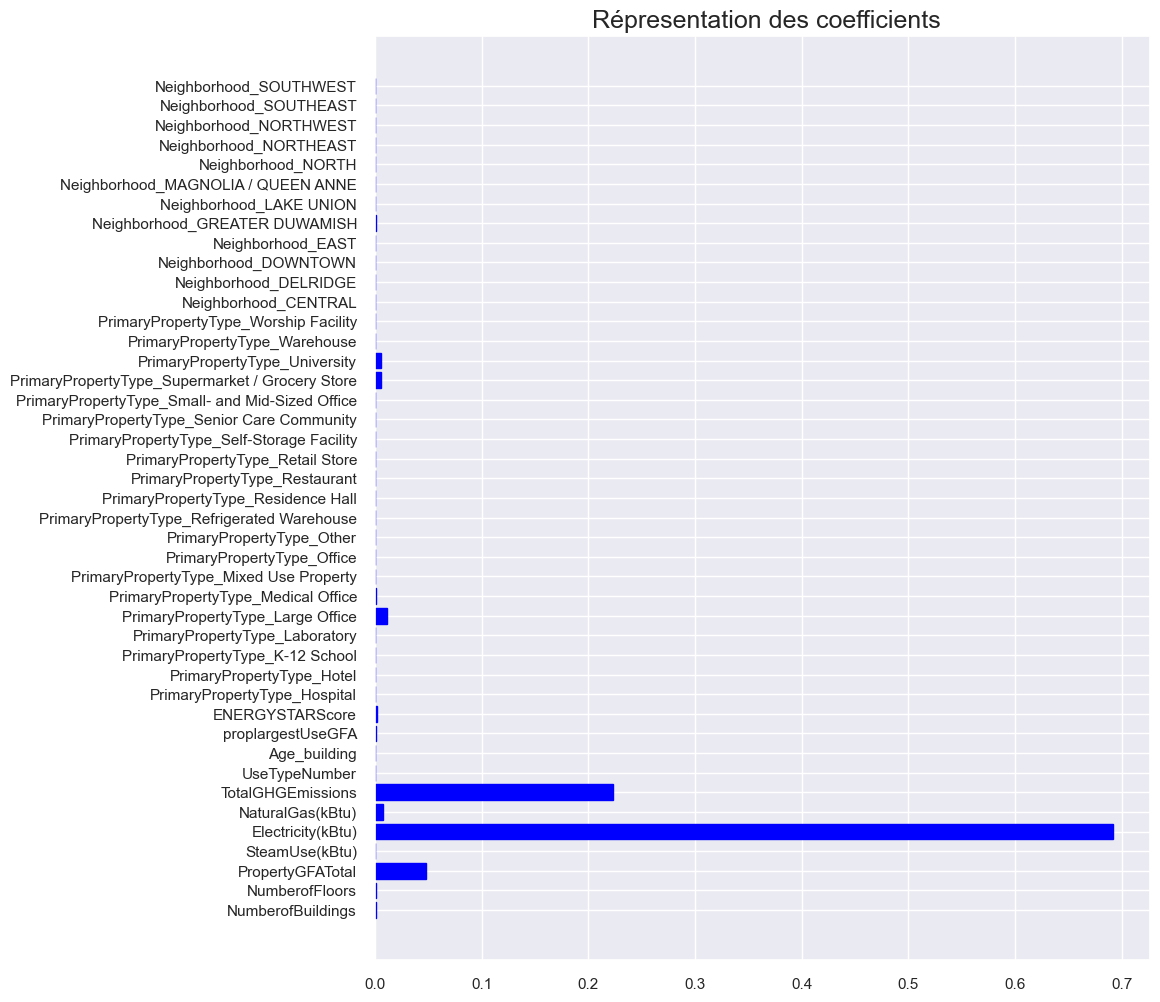

In [205]:
fig=plt.figure(figsize=[10,12])
fig.patch.set_alpha(0.7)
plt.title(" Répresentation des coefficients",size=18)
plt.barh(X_encode.columns, best_lgb_model['regressor'].feature_importances_,color="#0000FF",edgecolor='blue')


## Choix du modèle final

In [206]:
# Regression lineaire
score_Lr_Train = GS_lr.score(X_train, y_train)
score_Lr_Test = GS_lr.score(X_test, y_test)

# ElasticNet
score_EN_Train = best_elasticnet_model.score(X_train, y_train)
score_EN_Test = best_elasticnet_model.score(X_test, y_test)

# Random Forest
score_RF_Train = best_randf_model.score(X_train, y_train)
score_RF_Test = best_randf_model.score(X_test, y_test)

# XGBoost
score_XGB_Train = best_xgb_model.score(X_train, y_train)
score_XGB_Test = best_xgb_model.score(X_test, y_test)

# Light GBM
score_LGB_Train = best_lgb_model.score(X_train, y_train)
score_LGB_Test = best_lgb_model.score(X_test, y_test)

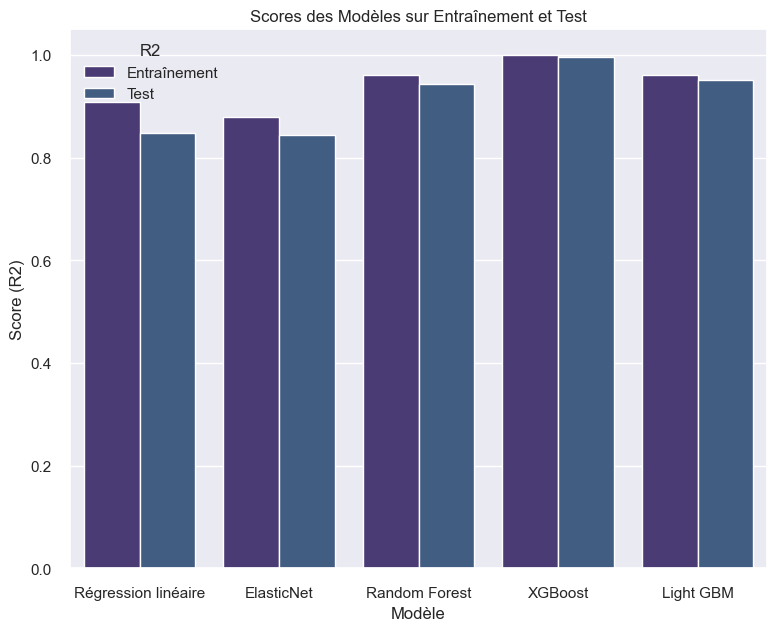

In [207]:
models = ['Régression linéaire', 'ElasticNet', 'Random Forest', 'XGBoost', 'Light GBM']
train_scores = [score_Lr_Train, score_EN_Train, score_RF_Train, score_XGB_Train, score_LGB_Train]
test_scores = [score_Lr_Test, score_EN_Test, score_RF_Test, score_XGB_Test, score_LGB_Test]

scores_df = pd.DataFrame({'Modèle': models * 2,
                          'Score': train_scores + test_scores,
                          'R2': ['Entraînement'] * len(models) + ['Test'] * len(models)})

sns.set_palette("viridis")

plt.figure(figsize=(9, 7))
sns.barplot(x='Modèle', y='Score', hue='R2', data=scores_df, ci=None)
plt.xlabel('Modèle')
plt.ylabel('Score (R2)')
plt.title('Scores des Modèles sur Entraînement et Test')
plt.legend(title='R2')

plt.show()

### Modèle final retenu : XGBoost

#### Score global

In [208]:
best_xgb_model.fit(X,Y)
print (f'Score final - : {best_xgb_model.score(X,Y):.7f}')

Score final - : 0.9998583


#### Prédiction de la consommation annuelle d'énergie par bâtiment

In [209]:
y_pred = best_xgb_model.predict(X)

#### Comparaison des valeurs prédites et des valeurs réelles

In [210]:
comparaison=pd.DataFrame(y_pred,columns=["Prédites"],index=Y.index)
comparaison["Réelles"]=Y
comparaison.head()

,Prédites,Réelles
0,7333504.5,7226362.5
1,8314854.0,8387933.0
2,72640496.0,72587024.0
3,6607788.5,6794584.0
4,14197995.0,14172606.0


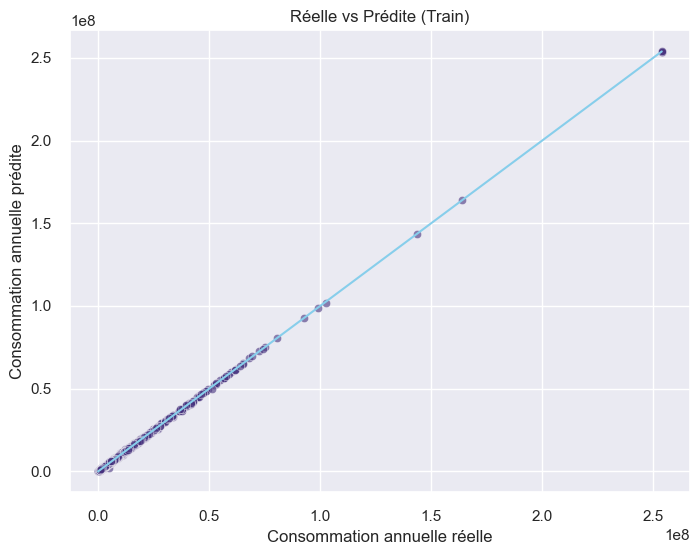

In [211]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x=Y, y=y_pred, alpha=0.6)
sns.lineplot(x=Y, y=Y, color='skyblue')  # Ligne de référence en rouge
plt.xlabel("Consommation annuelle réelle")
plt.ylabel("Consommation annuelle prédite")
plt.title("Réelle vs Prédite (Train)")

plt.show()

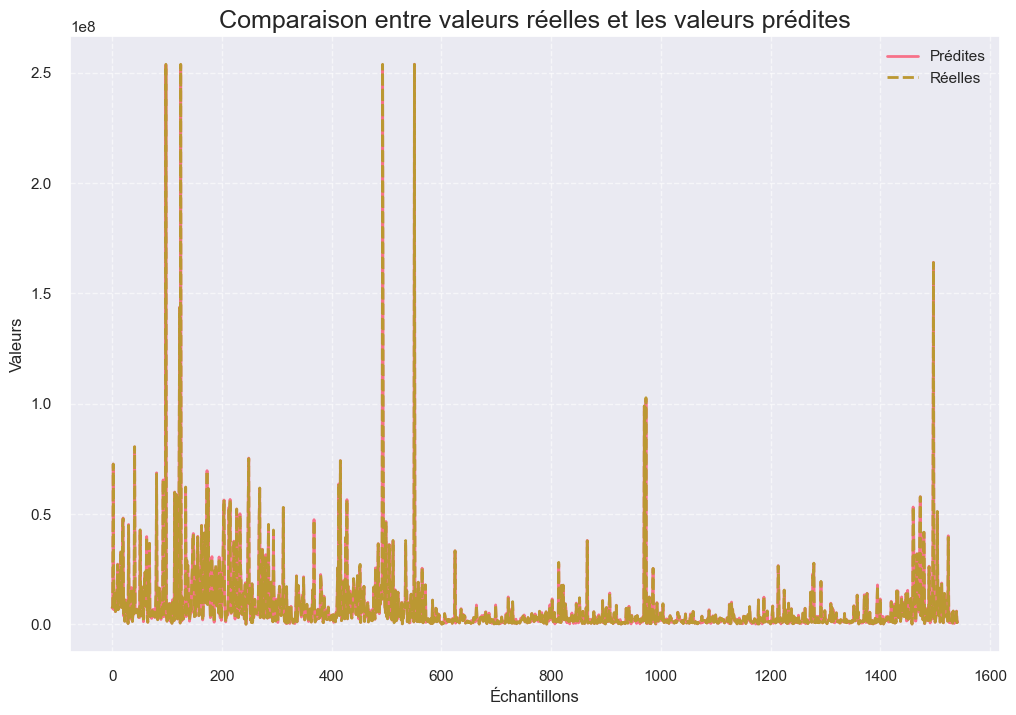

In [212]:
# graphique de comparaison
plt.figure(figsize=(12, 8))
sns.set_palette("husl")
sns.lineplot(data=comparaison[['Prédites', 'Réelles']], linewidth=2)
plt.title("Comparaison entre valeurs réelles et les valeurs prédites", size=18)
plt.xlabel("Échantillons")
plt.ylabel("Valeurs")
plt.legend(labels=['Prédites', 'Réelles'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()